# **The fourth in-class-exercise (40 points in total, 11/03/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
# Write your code here
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 6.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=76129799b87285745a5a57bebc77e507a2d7754f65840d71c5107c63325cf107
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=233da8661dcf879d278c6f0b78fc5cfb3befe5f4aac6c57ed4e5a3d86a7a39e6
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as p
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv("/content/test.csv")

#Cleaning the data
import re

def cleantext(tweets):
    text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) #removing Hashtag symbols.
    text = re.sub(r'RT[\s]+', '', text) #removing Retweet symbol (RT).
    text = re.sub(r'https?:\/\/\S+', '', text) #remove URL's.
    text = re.sub(r"www.\S+", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^A-Za-z0-9]"," ", text)#Filtering non-alphanumeric characters
    text = re.sub('\\n', '', text)#removing the '\n' character
    text = re.sub(r'[0-9]+', '', text)#removing numbers
    
    return text

df["Text"] = df["Text"].apply(cleantext)

# Convert to list
data = df.Text.values.tolist()

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
m = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
n = gensim.models.Phrases(m[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
mmod = gensim.models.phrases.Phraser(m)
nmod = gensim.models.phrases.Phraser(n)

# See trigram example
print(mmod[nmod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['optimistic', 'about', 'our', 'ability', 'to', 'prevent', 'the', 'next', 'pandemic', 'we', 'have', 'learned', 'so', 'much', 'from', 'covid', 'and', 'the', 'innovations', 'have', 'been', 'tremendous']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def rmv_stopwords(data):
    return [[words for words in simple_preprocess(str(document)) if words not in stop_words] for document in data]

def find_bigrams(data):
    return [mmod[document] for document in data]

def find_trigrams(data):
    return [mmod[nmod[document]] for document in data]

def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    output_text = []
    for sentence in text:
        document = nlp(" ".join(sentence)) 
        output_text.append([tkn.lemma_ for tkn in document if tkn.pos_ in allowed_postags])
    return output_text

In [ ]:
# Remove Stop Words
nostop_words_in_data = rmv_stopwords(data_words)

# Form Bigrams
bigrams_in_data = find_bigrams(nostop_words_in_data)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
lemmitized_data = lemmatization(bigrams_in_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(lemmitized_data[:1])

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


[['optimistic', 'ability', 'prevent', 'next', 'learn', 'much', 'covid', 'innovation', 'tremendous']]


In [ ]:
# Create Dictionary
dic = corpora.Dictionary(lemmitized_data)

# Create Corpus
data = lemmitized_data

# Term Document Frequency
corpus = [dic.doc2bow(text) for text in data]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [ ]:
dic[0]

'ability'

In [ ]:
[[(dic[id], frequency) for id, frequency in corp] for corp in corpus[:1]]

[[('ability', 1),
  ('covid', 1),
  ('innovation', 1),
  ('learn', 1),
  ('much', 1),
  ('next', 1),
  ('optimistic', 1),
  ('prevent', 1),
  ('tremendous', 1)]]

In [ ]:
lda_mdl = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dic,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
print(lda_mdl.print_topics())
doc_lda = lda_mdl[corpus]

[(0, '0.060*"work" + 0.041*"world" + 0.026*"talk" + 0.025*"time" + 0.024*"inspire" + 0.023*"make" + 0.023*"health" + 0.022*"young" + 0.020*"improve" + 0.019*"thank"'), (1, '0.046*"great" + 0.041*"learn" + 0.024*"thing" + 0.024*"even" + 0.019*"thank" + 0.017*"fight" + 0.017*"breakthrough" + 0.016*"problem" + 0.016*"science" + 0.015*"team"'), (2, '0.039*"fight" + 0.039*"disease" + 0.037*"day" + 0.030*"ever" + 0.029*"leadership" + 0.027*"alzheimer" + 0.023*"datum" + 0.021*"share" + 0.020*"first" + 0.017*"million"'), (3, '0.039*"climate_change" + 0.034*"need" + 0.034*"world" + 0.033*"make" + 0.029*"new" + 0.029*"help" + 0.024*"innovation" + 0.024*"see" + 0.023*"get" + 0.021*"take"'), (4, '0.081*"people" + 0.033*"year" + 0.030*"live" + 0.020*"change" + 0.019*"future" + 0.016*"country" + 0.016*"create" + 0.015*"poor" + 0.013*"power" + 0.013*"many"'), (5, '0.057*"energy" + 0.032*"technology" + 0.031*"partner" + 0.022*"want" + 0.022*"invest" + 0.021*"worker" + 0.018*"scientist" + 0.017*"clean"

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_mdl.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
cohrnce_mdl_lda = CoherenceModel(model=lda_mdl, texts=lemmitized_data, dictionary=dic, coherence='c_v')
cohrnce_lda = cohrnce_mdl_lda.get_coherence()
print('\nCoherence Score: ', cohrnce_lda)


Perplexity:  -7.418558179451499

Coherence Score:  0.3962540067031319


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim_models.prepare(lda_mdl, corpus, dic)
visualization

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.308422 -0.063532       1        1  21.503552
0      0.197929  0.098474       2        1  14.709382
7     -0.122867  0.238869       3        1  10.674910
4      0.021999  0.045292       4        1  10.585916
1     -0.013330  0.157435       5        1   9.142256
2      0.000280 -0.142832       6        1   8.934335
5     -0.083689 -0.106060       7        1   7.198467
9     -0.113917 -0.066072       8        1   5.977987
6     -0.114953 -0.036681       9        1   5.763993
8     -0.079874 -0.124892      10        1   5.509202, topic_info=                Term        Freq       Total Category  logprob  loglift
33            people  108.000000  108.000000  Default  30.0000  30.0000
42              work  125.000000  125.000000  Default  29.0000  29.0000
205   climate_change  106.000000  106.000000  Default  28.0000  28.0000
22              year  119.000000  119.000000  Default  27.0000  27.0000
15              good   49.000000   49.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1249           model    4.017286    4.797632  Topic10  -5.1505   2.7212
263        challenge   22.007079   27.568851  Topic10  -3.4497   2.6734
240          vaccine   14.134759   35.932601  Topic10  -3.8925   1.9657
76           country   15.494577   63.317421  Topic10  -3.8006   1.4911
390            still    6.959603   12.017328  Topic10  -4.6010   2.3525

[436 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
117       1  0.932708   accelerate
844       6  0.863504  accelerator
366       9  0.850946       access
118       6  0.224022       action
118       7  0.728072       action
...     ...       ...          ...
22        3  0.517881         year
22        4  0.367528         year
22        6  0.058470         year
22        9  0.050117         year
174       2  0.986957        young

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 8, 5, 2, 3, 6, 10, 7, 9])

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dic)

--2022-11-07 04:19:39--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-11-07 04:19:39--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  45.7MB/s    in 0.3s    

2022-11-07 04:19:39 (45.7 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
chrence_mdl_lda_mallet = CoherenceModel(model=ldamallet, texts=lemmitized_data, dictionary=dic, coherence='c_v')
chrence_lda_mallet = chrence_mdl_lda_mallet.get_coherence()
print('\nCoherence Score: ', chrence_lda_mallet)

[(2,
  [('life', 0.14885496183206107),
   ('work', 0.1297709923664122),
   ('live', 0.08015267175572519),
   ('save', 0.06297709923664122),
   ('partner', 0.05534351145038168),
   ('million', 0.04198473282442748),
   ('healthy', 0.02480916030534351),
   ('improve', 0.022900763358778626),
   ('prepare', 0.02099236641221374),
   ('happy', 0.019083969465648856)]),
 (1,
  [('book', 0.14361702127659576),
   ('read', 0.07624113475177305),
   ('lot', 0.07624113475177305),
   ('find', 0.05319148936170213),
   ('love', 0.0425531914893617),
   ('write', 0.040780141843971635),
   ('favorite', 0.03723404255319149),
   ('friend', 0.028368794326241134),
   ('recommend', 0.02304964539007092),
   ('approach', 0.01950354609929078)]),
 (4,
  [('year', 0.22627737226277372),
   ('learn', 0.10401459854014598),
   ('student', 0.06569343065693431),
   ('foundation', 0.05474452554744526),
   ('give', 0.051094890510948905),
   ('teacher', 0.03467153284671533),
   ('school', 0.023722627737226276),
   ('kid', 0.

In [ ]:
def cmpute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    chrence_val = []
    model_list = []
    for num_of_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_of_topics, id2word=dic)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        chrence_val.append(coherencemodel.get_coherence())

    return model_list, chrence_val

In [ ]:
model_list, coherence_values = cmpute_coherence_values(dictionary=dic, corpus=corpus, texts=lemmitized_data, start=2, limit=40, step=2)

In [ ]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
p.plot(x, coherence_values)
p.xlabel("Num Topics")
p.ylabel("Coherence score")
p.legend(("coherence_values"), loc='best')
p.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Number of Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimized_mdl = model_list[14]
#model_list[4] indicates that: model_list is a list that has been defined earlier and contains the number of topics and its coherence values.
# Since I have decided 10 to be the ideal number of topics, Topics number 30 is present in the 14th place of the list.
model_topics = optimized_mdl.show_topics(formatted=False)
pprint(optimized_mdl.print_topics(num_words=10))

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [1]:
# Write your code here
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as p

In [8]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tknizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    stop_wrds_eng = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tknizer.tokenize(i)
        # remove stop words from tokens
        rmv_stopped_tokens = [i for i in tokens if not i in stop_wrds_eng]
        # stem tokens
        stemmed_tokens = [stemmer.stem(i) for i in rmv_stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
preprocess_data(data)

[['i',
  'optimist',
  'abil',
  'prevent',
  'next',
  'pandem',
  'we',
  'learn',
  'much',
  'covid',
  'innov',
  'tremend'],
 ['the',
  'global',
  'fund',
  'one',
  'best',
  'invest',
  'global',
  'health',
  'fulli',
  'fund',
  'program',
  'next',
  'year',
  'critic',
  'end',
  'hiv',
  'tb',
  'malaria',
  'help',
  'ensur',
  'covid',
  'last',
  'pandem'],
 ['at',
  'end',
  'day',
  'paul',
  'last',
  'impact',
  'found',
  'patient',
  'love',
  'dearli',
  'peopl',
  'aliv',
  'today',
  'dedic',
  'life',
  'help'],
 ['hi',
  'work',
  'continu',
  'partner',
  'health',
  'incred',
  'organ',
  'co',
  'found',
  'it',
  'phenomen',
  'legaci'],
 ['paul',
  'never',
  'happier',
  'care',
  'patient',
  'one',
  'clinic',
  'help',
  'creat',
  'my',
  'heart',
  'goe',
  'famili',
  'friend',
  'colleagu',
  'peopl',
  'whose',
  'live',
  'touch'],
 ['what',
  'devast',
  'loss',
  'paul',
  'hero',
  'i',
  'fortun',
  'call',
  'friend',
  'i',
  'never',
  

In [10]:
def prep_corp(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictnry = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictnry.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictnry,doc_term_matrix

In [9]:
n_topics=7
words=10

In [22]:
def creat_gensim_lsa_mod(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    diti,doc_trm_mat=prep_corp(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_trm_mat, num_topics=number_of_topics, id2word = diti)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [23]:
def comp_cohre_value(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coher_value = []
    model_lst = []
    for i in range(start, stop, step):
        # generate LSA model
        model1 = LsiModel(doc_term_matrix, num_topics=i, id2word = dictionary)  # train model
        model_lst.append(model1)
        coherencemod = CoherenceModel(model=model1, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coher_value.append(coherencemod.get_coherence())
    return model_lst, coher_value

In [24]:
def plot_graph1(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prep_corp(doc_clean)
    model_lst, coher_value = comp_cohre_value(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    p.plot(x, coher_value)
    p.xlabel("Number of Topics")
    p.ylabel("Coherence score")
    p.legend(("coherence_values"), loc='best')
    p.show()

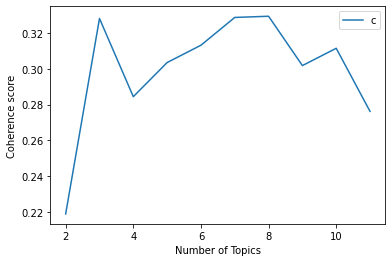

In [20]:
start,stop,step=2,12,1
plot_graph1(preprocess_data(data),start,stop,step)

In [25]:
# Write your code here
model=creat_gensim_lsa_mod(preprocess_data(data),n_topics,words)

[(0, '0.779*"i" + 0.185*"world" + 0.153*"climat" + 0.144*"work" + 0.139*"year" + 0.119*"one" + 0.113*"chang" + 0.099*"peopl" + 0.095*"help" + 0.088*"the"'), (1, '-0.519*"i" + 0.333*"world" + 0.302*"climat" + 0.208*"chang" + 0.198*"need" + 0.167*"help" + 0.150*"the" + 0.147*"work" + 0.136*"health" + 0.109*"countri"'), (2, '0.550*"climat" + 0.362*"chang" + -0.239*"health" + -0.180*"countri" + 0.152*"avoid" + -0.144*"vaccin" + 0.140*"disast" + -0.139*"the" + -0.138*"world" + -0.137*"pandem"'), (3, '0.749*"world" + -0.182*"year" + -0.176*"one" + -0.165*"countri" + -0.146*"vaccin" + -0.141*"new" + -0.137*"need" + 0.137*"around" + -0.133*"pandem" + -0.109*"us"'), (4, '-0.514*"work" + 0.487*"one" + -0.248*"health" + 0.203*"peopl" + 0.182*"world" + 0.149*"book" + 0.121*"new" + -0.110*"thank" + 0.102*"chang" + 0.096*"read"'), (5, '0.431*"year" + 0.384*"work" + 0.381*"one" + -0.248*"need" + 0.205*"chang" + -0.184*"help" + -0.168*"the" + -0.147*"i" + -0.140*"new" + 0.122*"peopl"'), (6, '-0.383*"y

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
# Write your code here
# Write your code here
import gensim
from collections import Counter
import gensim.corpora

from gensim.corpora import Dictionary
from gensim.models import lda2vec
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

c_size = 2000
k = 10  # number of desired word vectors
workers = 4  # number of threads to run in parallel
epochs = 3  # number of training epochs

# LDA2Vec requires a corpus of word counts
# transform corpus of counts to sparse matrix format
def sparse_bow_generator(corpus, dictionary):
    for documents in corpus:
        yield dictionary.doc2bow(documents)

# Define helper functions for plotting
def plot_lda2vec_tsne(lda_model):
    lda2vec_mdl = TSNE(n_components=2, perplexity=40, n_iter=250)
    lda2vec_vctrs = lda2vec_mdl.fit_transform(lda_model.layer1_size)

    fig, ax = plt.subplots(1, 1)
    ax.scatter(lda2vec_vctrs[:, 0], lda2vec_vctrs[:, 1])
    for label, x, y in zip(lda_model.vocab, lda2vec_vctrs[:, 0], lda2vec_vctrs[:, 1]):
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom'
        )
    plt.show()

def plot_lda2vec_pca(lda_model):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(lda_model.layer1_size)

    fig, ax = plt.subplots(1, 1)
    ax.scatter(pca_result[:, 0], pca_result[:, 1])
    for label, x, y in zip(lda_model.vocab, pca_result[:, 0], pca_result[:, 1]):
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom'
        )
    plt.show()
dictry = []
doc_clean = []
k = 10  # number of desired word vectors
# Instantiate and train the model
lda2vec_model = lda2vec.Lda2Vec(
    corpus_bow=0,
    num_topics=k,
    id2word=dictry,
    chunksize=csize,
    distributed=True,
    alpha=1e-1,
    eta=1e-2,
    decay=0.5,
    offset=1.0,
    iterations=epochs,
    dm_mean=1,
    dm=0,
    ns_exponent=0.75,
    minimum_probability=0.01,
    callbacks=[],
    random_state=42,
    workers=workers,
    eval_every=10,
    verbose=2
)

# Plot the topic vectors
plot_lda2vec_tsne(lda2vec_mdl)
plot_lda2vec_pca(lda2vec_mdl)

# Compute Coherence Score
chrence_mdl_lda = CoherenceModel(model=lda2vec_mdl, texts=doc_clean, dictionary=dictry, coherence='c_v')
coherence_lda = chrence_mdl_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [27]:
# Write your code here
%%capture
!pip install bertopic

In [ ]:
from sklearn.datasets import fetch_20newsgroups
documents = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [ ]:
from bertopic import BERTopic

t_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = t_model.fit_transform(documents)

In [ ]:
freq = t_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,6848,-1_to_the_of_is
1,0,1837,0_game_team_games_he
2,1,579,1_key_clipper_chip_encryption
3,2,530,2_ites_hello_cheek_hi
4,3,451,3_fbi_batf_fire_koresh


In [ ]:
t_model.get_topic(0)

[('game', 0.010360747394346162),
 ('team', 0.009026594535340651),
 ('games', 0.007191909791422302),
 ('he', 0.00702507316039493),
 ('players', 0.0063332216277284),
 ('season', 0.006239589210298072),
 ('hockey', 0.006153301605191258),
 ('play', 0.005784252948113199),
 ('25', 0.005647747925413993),
 ('year', 0.005593434745566921)]

In [ ]:
t_model.visualize_topics()

In [ ]:
t_model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
t_model.update_topics(documents, n_gram_range=(1, 2))

In [ ]:
similar_topics, similarity = t_model.find_topics("vehicle", top_n=5); similar_topics

[6, 5, 10, 132, 189]

In [ ]:
t_model.get_topic(71)

[('drugs', 0.03859641672907662),
 ('drug', 0.0343094626800166),
 ('the drug', 0.010804978720433504),
 ('drug users', 0.010630901781107012),
 ('drug use', 0.008930530121955571),
 ('on drugs', 0.008853112469947844),
 ('cocaine', 0.00868939684042989),
 ('marijuana', 0.008037477109760013),
 ('war on', 0.007868623634530324),
 ('users', 0.006239031929900212)]

In [ ]:
# Save model
t_model.save("my_model")	

In [ ]:
# Load model
my_model = BERTopic.load("my_model")

In [ ]:
t_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

In [ ]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
t_model = BERTopic(embedding_model=sentence_model, verbose=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
from sentence_transformers import SentenceTransformer, util
mdl = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

query = mdl.encode('How big is London')
passage = mdl.encode(['London has 9,787,426 inhabitants at the 2011 census',
                                  'London is known for its finacial district'])

print("Similarity:", util.dot_score(query, passage))

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Similarity: tensor([[0.5472, 0.6330]])


## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)
'''Topic Modelling can be evaluated by the concept of Topic Coherence.There are many techniques that are used to obtain topic models.They are: 
 Latent Semantic Analysis(LSA) and Latent Dirichlet Allocation (LDA), lda2vec and  BERTopic .
LDA:
The two main inputs to the LDA topic model are the dictionary and the corpus. Gensim creates a unique id for each word in the document.In addition to the corpus and dictionary, we need to provide the number of topics as well.
We can use LDA visualization tool pyLDAvis, by trying a few numbers of topics and comparing the results.Topic coherence is one of the main techniques used to estimate the number of topics.
We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics.
The  plot of coherence value and number of topics shows that coherence score decreases with the number of topics.Optimum topics score is observed at 10.
and also coherence value observed for the data using LDA algorithm is 0.59

LSA:
LSA is typically used as a dimension reduction or noise reducing technique.
The best way to determine k (number of topics) in topic modeling, is by using Topic coherence measure which is a realistic measure for identifying the number of topics.The high value of topic coherence score model will be considered as a good topic model.
For the Plot i.e.,coherence value and number of topics using LSA algorithm the Optimum coherence score is observed at 0,43 with topic at 6.

So from the analysis, LDA gives better results than LSA .'''


